In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.container { 
    width: 100% !important;
}
</style>
"""))

In [3]:
import torch
from torch import nn, Tensor
from model.fuzzy_layer import FuzzyUnsignedConjunction, FuzzyUnsignedDisjunction, FuzzyNumKeepup, keepidx, fuzzy_dropup
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, DrasticLogic, SchweizerSklarLogic
from model.fuzzy_layer import FuzzyParam, FuzzyLoss
from model.bool_logic import BoolLogic
from cache import TrainingRegime, TestMetric
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from util import shuffle

logic = BoolLogic()
flogic = ProductLogic()

In [4]:
device = 'cuda'

In [5]:
def true_conjunction(weights, xs):
    return logic.conjoin(logic.implies(weights, xs), dim=1)

In [6]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class WeightedDataset(Dataset):
    def __init__(self, N, D, K):
        super().__init__()
        self.samples = torch.zeros((N, D), dtype=torch.bool)
        self.samples[:,:K] = True
        self.samples = shuffle(self.samples, dim=-1)
        
    def __len__(self):
        return self.samples.size(0)
        
    def __getitem__(self, idx):
        return self.samples[idx]

class BinaryDataset(Dataset):
    def __init__(self, shape, N):
        self.samples = torch.distributions.bernoulli.Bernoulli(
            0.5
        ).sample(
            torch.Size([N, *shape])
        ).bool()
        
    def __len__(self):
        return self.samples.size(0)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [7]:
class CorrectParamMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
    
    def name(self):
        return "correct-param"

    def measure_model(self, model, _):
        params = (model.weights.value() > 0.5).flatten()
        no_correct = (self.ideal_params == params).sum()
        return (no_correct / params.numel()).item()
    
class ParamMeanDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "param-mean-distance"
    
    def measure_model(self, model, _):
        params = model.weights.value().flatten()
        crispness = (params - self.ideal_params.float()).abs().mean()
        return crispness.item()
    
class ParamMaxDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "param-max-distance"
    
    def measure_model(self, model, _):
        params = model.weights.value().flatten()
        crispness = (params - self.ideal_params.float()).abs().max()
        return crispness.item()
    
class CorrectOutputMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "correct-output"
    
    def measure_model(self, model, it):
        count = 0
        correct = 0
        for bs in it():
            bs = model._logic.encode(bs.to(device))
            pred = (model(bs) > 0.5).flatten()
            true = true_conjunction(self.ideal_params, bs)
            correct += (pred == true).sum().item()
            count += bs.size(dim=0)
        return (correct / count)
    
class OutputDistanceMetric(TestMetric):
    def __init__(self, ideal_params):
        self.ideal_params = ideal_params
        
    def name(self):
        return "output-distance"
    
    def measure_model(self, model, it):
        count = 0
        correct = 0
        for bs in it():
            bs = model._logic.encode(bs.to(device))
            pred = model(bs).flatten()
            true = true_conjunction(self.ideal_params, bs)
            correct += (pred - true.float()).abs().sum().item()
            count += bs.size(dim=0)
        return (correct / count)

In [8]:
def rand_n_true(shape, N):
    falses = torch.zeros(shape, dtype=torch.bool)
    falses = falses.view(-1)
    falses[:N] = True
    falses = falses[torch.randperm(falses.size(0))]
    return falses.view(*shape)

In [9]:
class ConjModel(torch.nn.Module):
    def __init__(self, no_dims, logic, keepn, fix_imbalance):
        super().__init__()
        self.model = FuzzyUnsignedConjunction(
            in_features=no_dims, 
            out_features=1, 
            logic=logic, 
            keepn=keepn,
        )
        
    def forward(self, xs, y):
        y_hat = self.model(xs).squeeze()
        return self.loss(y, y_hat)

In [10]:
class ConjunctionRegime(TrainingRegime):
    def __init__(self, logic, no_dims=1000, no_terms=5, no_runs=1, keepn=None, optim='adam', lr=1e-2, bce=False):
        super().__init__("./conjunctions/", no_runs)
        
        self.flogic = logic
        self.no_dims = no_dims
        self.no_terms = no_terms
        self.keepn = keepn
        self.optim = 'adam' if optim == 'adam' else 'sgd'
        self.lr = lr
        self.bce = bce
        
        self.weights = self.cache(
            "weights", 
            lambda: rand_n_true([self.no_dims], self.no_terms).to(device)
        )
        
        self.tests = [
            OutputDistanceMetric(self.weights),
            CorrectOutputMetric(self.weights),
            CorrectParamMetric(self.weights),
            ParamMeanDistanceMetric(self.weights),
            ParamMaxDistanceMetric(self.weights),
        ]
        
        self.training_dataset = BinaryDataset([self.no_dims], 10_000)
        self.testing_dataset = BinaryDataset([self.no_dims], 10_000)
        
        self.optims = [None] * no_runs
        self.losses = [None] * no_runs
        
    def get_logic_str(self):
        if isinstance(self.flogic, ProductLogic):
            return "product"
        elif isinstance(self.flogic, MinimumLogic):
            return "minimum"
        elif isinstance(self.flogic, LukasiewiczLogic):
            return "lukasiewicz"
        elif isinstance(self.flogic, DrasticLogic):
            return "drastic"
        elif isinstance(self.flogic, SchweizerSklarLogic):
            return "schweizer-sklar"
        else:
            return "fuzzy"
        
    def get_optim(self, run_no):
        optim = self.optims[run_no - 1]
        if optim is None:
            model = self.get_loaded_model(run_no)
            optim = self.optims[run_no - 1] = (
                torch.optim.SGD(model.parameters(), lr=self.lr)
                if self.optim == "sgd"
                else torch.optim.Adam(model.parameters(), lr=self.lr)
            )
        return optim
    
    def get_loss(self, run_no):
        loss = self.losses[run_no - 1]
        if loss is None:
            loss = self.losses[run_no - 1] = (
                FuzzyLoss(logic=self.flogic, exp=10 if not self.bce else 1, bce=self.bce)
            )
        return loss
        
    def regime_str(self):
        keep_str = "" if self.keepn is None else " | KEEP N = %s" % self.keepn
        bce_str = " | BCE" if self.bce else ""
        return (
            "CONJUNCTIONS | %s, LR = %s | %s LOGIC | %s DIMENSIONS | %s TERMS%s%s"
            % (
                self.optim.upper(), 
                self.lr,
                self.get_logic_str().upper(), 
                self.no_dims, 
                self.no_terms, 
                keep_str,
                bce_str
                
            )
        ) 
        
    def regime_filename_elems(self):
        elems = [
            "conj", 
            self.optim,
            str(self.lr),
            self.get_logic_str(),
            "%sdims" % self.no_dims,
            "%sterms" % self.no_terms
        ]
        if self.keepn is not None:
            elems.append("keep%s" % self.keepn)
        if self.bce is not None:
            elems.append("bce")
        return elems
        
    def training_dataloader(self, run_no):
        return DataLoader(self.training_dataset, batch_size=128)
    
    def testing_dataloader(self, run_no):
        return DataLoader(self.testing_dataset, batch_size=128)
    
    def training_step(self, run_no, model):
        optim = self.get_optim(run_no)
        loss_fn = self.get_loss(run_no)
        
        def step(bs):
            bs = bs.cuda()
            cjs = true_conjunction(self.weights, bs)
            cj_hats = model(self.flogic.encode(bs)).squeeze()
            loss = loss_fn(self.flogic.encode(cjs), cj_hats)
                
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        return step
        
    def new_model(self):
        return FuzzyUnsignedConjunction(
            in_features=self.no_dims,
            out_features=1,
            logic=self.flogic, 
            keepn=self.keepn,
        ).to(device)

In [11]:
def defer_regime(*args, **kargs):
    def return_regime():
        return ConjunctionRegime(*args, **kargs)
    return return_regime

no_runs = 1

prod = ProductLogic()
ss = SchweizerSklarLogic(torch.tensor(-2.0).to(device))
minl = MinimumLogic()
luk = LukasiewiczLogic()

regimes = [
    defer_regime(logic=prod, no_dims=10, no_terms=1, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=100, no_terms=1, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=1000, no_terms=1, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=10000, no_terms=1, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=10, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=100, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=1000, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=10000, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=10, no_terms=20, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=100, no_terms=20, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=1000, no_terms=20, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=10000, no_terms=20, no_runs=no_runs, bce=True),
    defer_regime(logic=prod, no_dims=10, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=prod, no_dims=100, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=prod, no_dims=1000, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=prod, no_dims=10000, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=prod, no_dims=10, no_terms=5, no_runs=no_runs, keepn=50, bce=True, optim='sgd'),
    defer_regime(logic=prod, no_dims=100, no_terms=5, no_runs=no_runs, keepn=50, bce=True, optim='sgd'),
    defer_regime(logic=prod, no_dims=1000, no_terms=5, no_runs=no_runs, keepn=50, bce=True, optim='sgd'),
    defer_regime(logic=prod, no_dims=10000, no_terms=5, no_runs=no_runs, keepn=50, bce=True, optim='sgd'),
    defer_regime(logic=ss, no_dims=10, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=ss, no_dims=100, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=ss, no_dims=1000, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=ss, no_dims=10000, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=ss, no_dims=10, no_terms=20, no_runs=no_runs, bce=True),
    defer_regime(logic=ss, no_dims=100, no_terms=20, no_runs=no_runs, bce=True),
    defer_regime(logic=ss, no_dims=1000, no_terms=20, no_runs=no_runs, bce=True),
    defer_regime(logic=ss, no_dims=10000, no_terms=20, no_runs=no_runs, bce=True),
    defer_regime(logic=ss, no_dims=10, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=ss, no_dims=100, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=ss, no_dims=1000, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=ss, no_dims=10000, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=ss, no_dims=10, no_terms=5, no_runs=no_runs, keepn=50, bce=True, optim='sgd'),
    defer_regime(logic=ss, no_dims=100, no_terms=5, no_runs=no_runs, keepn=50, bce=True, optim='sgd'),
    defer_regime(logic=ss, no_dims=1000, no_terms=5, no_runs=no_runs, keepn=50, bce=True, optim='sgd'),
    defer_regime(logic=ss, no_dims=10000, no_terms=5, no_runs=no_runs, keepn=50, bce=True, optim='sgd'),
    defer_regime(logic=minl, no_dims=10, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=minl, no_dims=100, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=minl, no_dims=1000, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=minl, no_dims=10000, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=minl, no_dims=10, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=minl, no_dims=100, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=minl, no_dims=1000, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=minl, no_dims=10000, no_terms=5, no_runs=no_runs, keepn=50, bce=True),
    defer_regime(logic=luk, no_dims=10, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=luk, no_dims=100, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=luk, no_dims=1000, no_terms=5, no_runs=no_runs, bce=True),
    defer_regime(logic=luk, no_dims=10000, no_terms=5, no_runs=no_runs, bce=True),
]

no_runs = 3

"""
regimes = [
    #defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, no_runs=1, bce=True),
    #defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, no_runs=1, bce=True),
    #defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, no_runs=1, bce=True),
    #defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, no_runs=1, bce=True),
    defer_regime(logic=ss_logic, no_dims=10, no_terms=5, no_runs=1, bce=True),
    defer_regime(logic=ss_logic, no_dims=100, no_terms=5, no_runs=1, bce=True),
    defer_regime(logic=ss_logic, no_dims=1000, no_terms=5, no_runs=1, bce=True),
    defer_regime(logic=ss_logic, no_dims=10000, no_terms=5, no_runs=1, bce=True),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=1, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=20, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=11),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=1, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=1, keepn=50, no_runs=5),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=1, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=20, keepn=50, no_runs=10),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=20, keepn=50, no_runs=5),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=20, keepn=50, no_runs=3),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=ProductLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-0),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=10, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=5, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=3, lr=1e-1, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=300, no_terms=5, keepn=50, no_runs=10, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=500, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=1000, no_terms=5, keepn=50, no_runs=3, lr=1e-0, optim='sgd'),
    defer_regime(logic=MinimumLogic(), no_dims=10000, no_terms=5, keepn=50, no_runs=5, lr=1e-0, optim='sgd'),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=100, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=300, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=500, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=1000, no_terms=5, keepn=50, no_runs=5),
    defer_regime(logic=SchweizerSklarLogic(torch.tensor(-2.0).to(device)), no_dims=10000, no_terms=5, keepn=50, no_runs=3),
    defer_regime(logic=LukasiewiczLogic(), no_dims=10, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=30, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=50, no_terms=5, keepn=50, no_runs=10),
    defer_regime(logic=LukasiewiczLogic(), no_dims=100, no_terms=5, keepn=50, no_runs=10),
]
"""

torch.autograd.set_detect_anomaly(True)
if True:
    for regime_f in regimes:
        regime = regime_f()
        regime.load_latest_models()
        regime.load_all_results()
        for i in range(1, regime.no_runs + 1):
            regime.loop_until(i, 40)
        del regime

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #4…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #4…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #4…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #5…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #5…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #5…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #6…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #6…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #6…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #7…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #7…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #7…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #8…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #8…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #8…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #9…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #9…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #9…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #1…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #2…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #3…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #4…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #4…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #4…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | SGD, LR = 0.01 | PRODUCT LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | ADAM, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, …

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1,…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | SGD, LR = 0.01 | SCHWEIZER-SKLAR LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch #…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 100 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch …

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 1000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoch…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

[CONJUNCTIONS | ADAM, LR = 0.01 | MINIMUM LOGIC | 10000 DIMENSIONS | 5 TERMS | KEEP N = 50 | BCE] Run #1, Epoc…

In [27]:
import matplotlib.cm as cm
import matplotlib.patches as mpatches

def plot_regime(regime, metric, color, ax):
    
    try:

        regime.load_latest_models()
        regime.load_all_results()

        for i in range(0, 10):
            if regime.results[i] is None:
                if i == 0:
                    return False
                break
            plt.plot(
                regime.results[i]['epoch'], 
                regime.results[i][metric],
                color=color,
                alpha=0.3
            )

        return True
    
    except:
        return False
        
def plot_regimes_over_logics(
    ax,
    metric='correct-param',
    #logic, 
    no_dims=1000, 
    no_terms=5, 
    no_runs=11, 
    keepn=50, 
    optim='adam', 
    lr=1e-2,
    bce=True,
):
    logics = [
        ProductLogic(),
        MinimumLogic(),
        SchweizerSklarLogic(torch.tensor(-2.0).to(device)),
        LukasiewiczLogic(),
    ]
    
    logic_labels = [
        "Product Logic",
        "Minimum Logic",
        "Schweizer-Sklar Logic (b = -2.0)",
        "Lukasiewicz Logic"
    ]
    
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric)
    ax.set_xlim(1,40)
    
    lines = []
    
    for idx, logic in enumerate(logics):
        regime = ConjunctionRegime(logic=logic, no_dims=no_dims, no_terms=no_terms, keepn=keepn, no_runs=no_runs, optim=optim, lr=lr, bce=bce)
        color = cm.Dark2(idx / ((len(logics) - 1)))
        if plot_regime(regime, metric, color, ax):
            lines.append(mpatches.Patch(color=color, label=logic_labels[idx]))
                    
    ax.legend(handles=lines)
    
    
def plot_regimes_over_ndims(
    ax,
    metric='correct-param',
    logic=ProductLogic(), 
    #no_dims=1000, 
    no_terms=5, 
    no_runs=11, 
    keepn=50, 
    optim='adam', 
    lr=1e-2,
    bce=True,
):
    
    no_dims = [
        10, 
        #30, 
        #50, 
        100, 
        #300, 
        #500, 
        1000, 
        10000
    ]
    
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric)
    ax.set_xlim(1,40)
    
    lines = []
    
    for idx, no_dim in enumerate(no_dims):
        regime = ConjunctionRegime(logic=logic, no_dims=no_dim, no_terms=no_terms, keepn=keepn, no_runs=no_runs, optim=optim, lr=lr, bce=bce)
        color = cm.rainbow(idx / (len(no_dims) - 1))
        if plot_regime(regime, metric, color, ax):
            lines.append(mpatches.Patch(color=color, label="D = %s" % no_dim))
                    
    ax.legend(handles=lines)

Fig 2.6

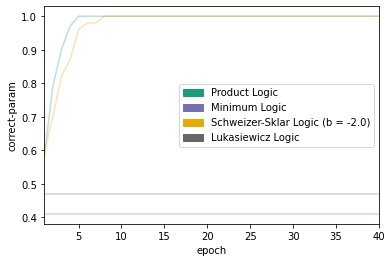

In [28]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=100, keepn=None)

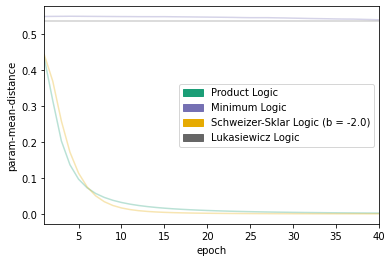

In [29]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=100, keepn=None, metric='param-mean-distance')

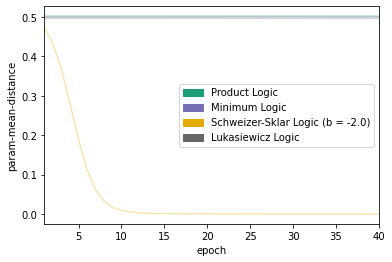

In [31]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=10000, keepn=None, metric='param-mean-distance')

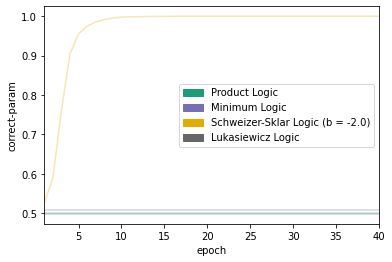

In [30]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=10000, keepn=None,)

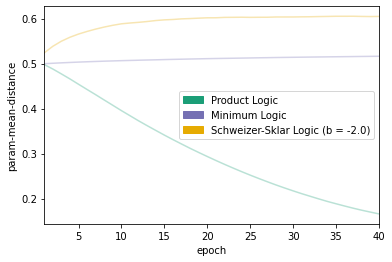

In [32]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=10000, keepn=50, metric='param-mean-distance')

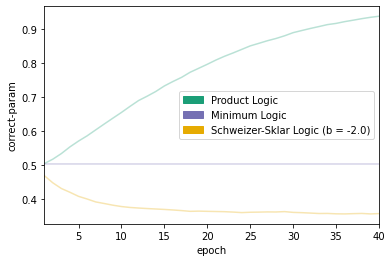

In [33]:
fig, ax = plt.subplots()

plot_regimes_over_logics(ax, no_dims=10000, keepn=50)

Fig 2.3

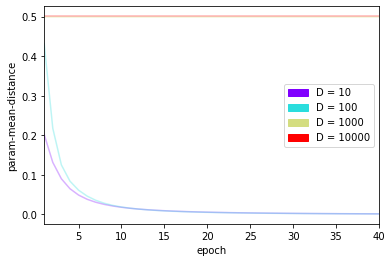

In [17]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=None, no_terms=1)

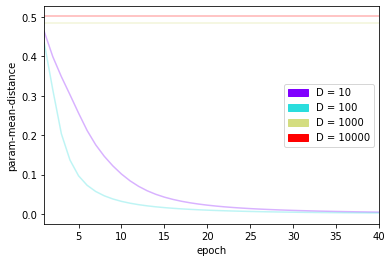

In [18]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=None)

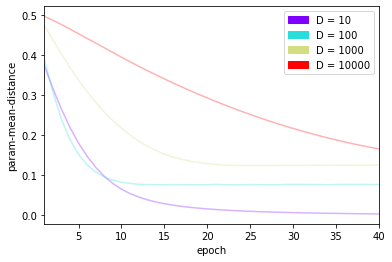

In [19]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic())

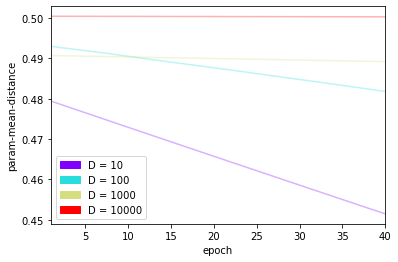

In [20]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), optim='sgd')

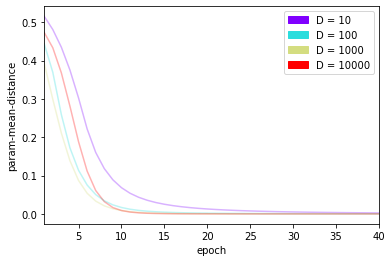

In [35]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ss, keepn=None)

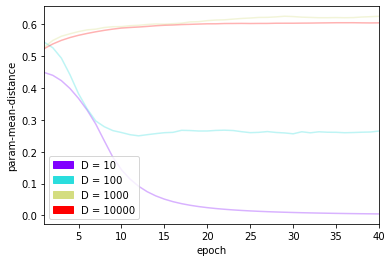

In [36]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ss)

Fig 2.4

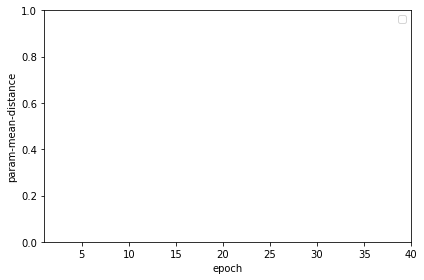

In [21]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=50, no_terms=1)
fig.tight_layout()

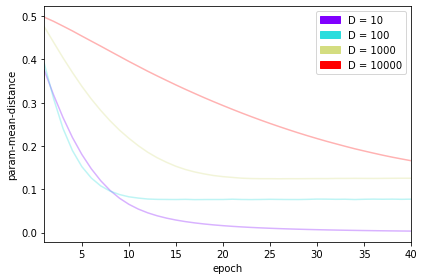

In [22]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=50, no_terms=5)

fig.tight_layout()

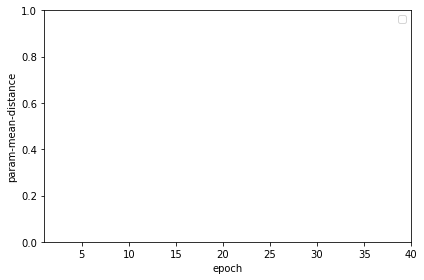

In [23]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='param-mean-distance', logic=ProductLogic(), keepn=50, no_terms=20)

fig.tight_layout()

Fig 2.5

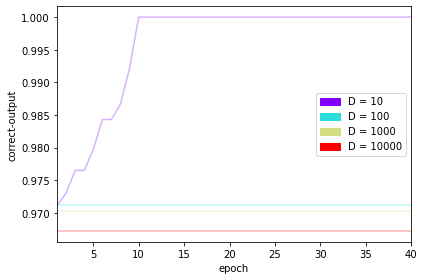

In [24]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='correct-output', logic=ProductLogic(), keepn=50)

fig.tight_layout()

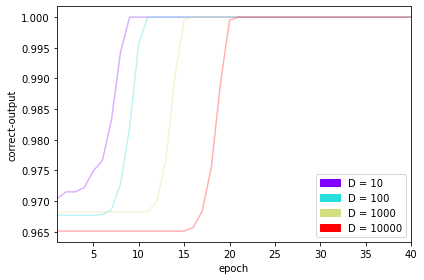

In [40]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='correct-output', logic=ss, keepn=None)

fig.tight_layout()

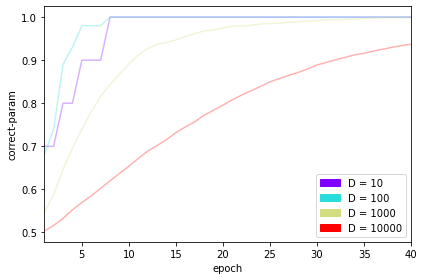

In [25]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='correct-param', logic=ProductLogic(), keepn=50)

fig.tight_layout()

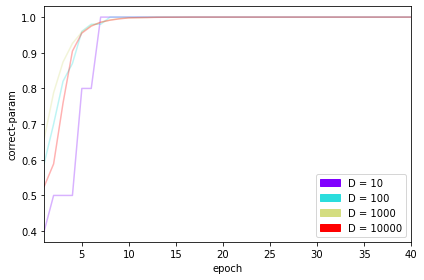

In [41]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='correct-param', logic=ss, keepn=None)

fig.tight_layout()

TypeError: plot_regimes_over_ndims() got an unexpected keyword argument 'fix_imbalance'

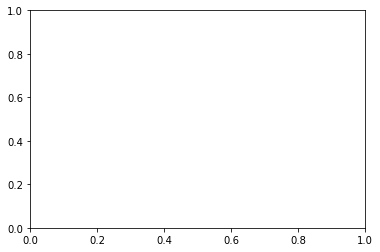

In [26]:
fig, ax = plt.subplots()

plot_regimes_over_ndims(ax, metric='correct-param', logic=ProductLogic(), keepn=None, fix_imbalance=True)

fig.tight_layout()